# Section 7.1.2: The degree-corrected stochastic block model

This page contains simulations in Section 7.1.2.

## Contents

    - Limiting spectrum and isolated eigen-pairs of a $3$-class DC-SBM
    - Overlap performance of different $\alpha$ on DS-SBM for bimodal $q_i$
    - FUNCTIONS


## Limiting spectrum and isolated eigen-pairs of a $3$-class DC-SBM



In [31]:
import numpy as np
import itertools
import scipy.sparse.linalg
import sklearn.cluster
import matplotlib.pyplot as plt
pi = np.pi

Text(0.5, 0, 'Eigenvector $2$')

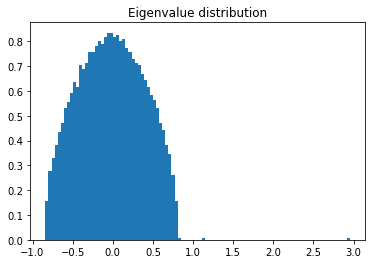

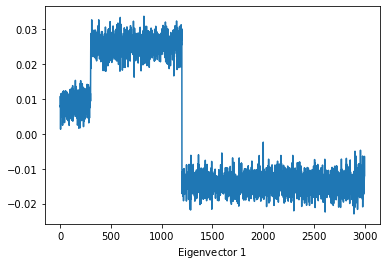

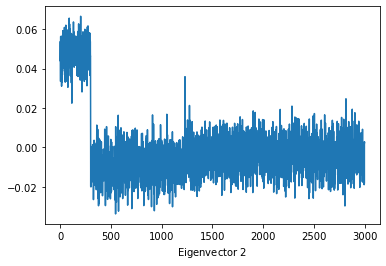

In [28]:
n = 3000
cs = np.array([0.1,0.3,0.6])
ns = n*cs
k = len(cs)
j = lambda i : np.concatenate([np.zeros(int(np.sum(ns[:i]))),np.ones(int(ns[i])),np.zeros(int(np.sum(ns[i+1:])))]).reshape(n,1)
J = np.concatenate([j(0),j(1),j(2)],1)

testcase = 'left'
if testcase == 'left':
    q = 0.1*np.random.randint(0,2,n)+ 0.8
    M = np.array([[10, 0, 0],[0, 10, 0],[0, 0, 10]])
if testcase == 'right':
    q = 0.8*np.random.randint(0,2,n)+ 0.1
    M = np.array([[5, 0, 0],[0, 5, 0],[0, 0, 5]])

C = 1 + M/np.sqrt(n)
P = np.diag(q)@(J@C@(J.T))@np.diag(q)

A = np.random.binomial(1,P,(n,n))
A = np.tril(A,-1)+np.tril(A,-1).T

d = np.sum(A,0);

B = 1/np.sqrt(n)*(A-np.outer(d,d)/np.sum(d))
eigs_B,V_B = np.linalg.eig(B)

idx = eigs_B.argsort()[::-1]   
eigs_B = eigs_B[idx]
V_B = V_B[:,idx]

edges = np.linspace(eigs_B[-1],eigs_B[0],100)

plt.hist(eigs_B, bins=edges,weights=1/n/(edges[1]-edges[0])*np.ones(n))
plt.title('Eigenvalue distribution')

plt.figure()
plt.plot(V_B[:,0])
plt.xlabel(r'Eigenvector $1$')

plt.figure()
plt.plot(V_B[:,1])
plt.xlabel(r'Eigenvector $2$')

_ = plt.show()

## Overlap performance of different $\alpha$ on DS-SBM for bimodal $q_i$

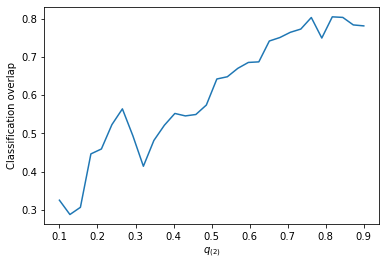

In [120]:
n = 3000
cs = np.array([0.1,0.3,0.6])
ns = n*cs
k = len(cs)
j = lambda i : np.concatenate([np.zeros(int(np.sum(ns[:i]))),np.ones(int(ns[i])),np.zeros(int(np.sum(ns[i+1:])))]).reshape(n,1)
J = np.concatenate([j(0),j(1),j(2)],1)

option_alpha = 'optim' # 'optim' or 'any'

range_q2 = np.linspace(0.1,0.9,30)

loops = 50
classif_overlap = np.zeros( (len(range_q2),loops) )

q1 = .1

for range_index,q2 in enumerate(range_q2):
    for loop in range(loops):
        q = (q2-q1)*(np.random.rand(n)>3/4)+ q1
        M = 15*np.array([[1, -1, -1],[-1, 1, -1],[-1, -1, 1]])
        C = 1 + M/np.sqrt(n)
                
        JCJ = np.dot(np.dot(J,C),J.T)
        P = np.minimum(np.multiply(q,np.multiply(q,JCJ).T),1)
        
        A = np.random.binomial(1,P,(n,n))
        trilA = np.tril(A,-1)
        A = trilA+trilA.T

        d = np.sum(A,0)

        if option_alpha == 'optim':
            alpha = find_optim_alpha(d)
        else:
            alpha = 1/2
            
        d_malpha = d**(-alpha)
        d_malphap1 = d_malpha*d
        L = np.sum(d)**alpha*( np.multiply(d_malpha,np.multiply(d_malpha,A).T) - np.outer(d_malphap1,d_malphap1)/np.sum(d) )/np.sqrt(n)
        
        nb_eig = 2
        V_L = scipy.sparse.linalg.eigsh(L,nb_eig,which='LA')[1]
        d_alpham1 = d**(alpha-1)
        V = np.real(np.multiply(d_alpham1,V_L.T)).T
        V_means=np.zeros( (k,nb_eig) )
        for i in range(k):
            V_means[i,:]=np.mean(V[int(np.sum(ns[:i])):int(np.sum(ns[:i+1])),:],0)

        kmeans_output = sklearn.cluster.KMeans(n_clusters=k, init=V_means, n_init=1).fit_predict(V)

        vec=np.zeros(n)
        tmp=0
        perms = list(itertools.permutations(list(range(k))))
        for perm in perms:
            for i in range(k):
                vec[int(np.sum(ns[:i])):int(np.sum(ns[:i+1]))]=perm[i]

            if np.sum(kmeans_output==vec)>tmp:
                tmp=np.sum(kmeans_output==vec)
                best_vec=vec.copy()

        classif_overlap[range_index,loop] = (np.sum(best_vec==kmeans_output)/n -1/k)/(1- 1/k)

plt.plot(range_q2,np.mean(classif_overlap,1))
plt.xlabel(r'$q_{(2)}$')
plt.ylabel(r'Classification overlap')
_ = plt.show()

## FUNCTIONS

In [37]:
def find_optim_alpha(d):

    n = len(d)

    q_estim = d/np.sqrt(np.sum(d))
    range_alpha = np.linspace(0,1,100)
    limit = np.zeros(len(range_alpha))

    for alpha_index,alpha in enumerate(range_alpha):

        q_estim_1_2alpha = q_estim**(1-2*alpha)
        q_estim_2_2alpha = q_estim**(2-2*alpha)

        left_edge = 0
        right_edge = 100
        found_a_valid_point = False

        watchdog1 = 1
        watchdog1_max = 1e3

        tilde_g = 0
        tilde_g_tmp = 1
        while np.abs(tilde_g- tilde_g_tmp)>1e-5 and watchdog1<watchdog1_max:
            x = (left_edge + right_edge)/2
            watchdog2 = 1
            watchdog2_max = 1e2

            g_vec = np.zeros(2)
            g_vec_tmp = np.ones(2)

            while np.max(np.abs(g_vec - g_vec_tmp))>1e-7 and watchdog2<watchdog2_max:
                g_vec_tmp = g_vec

                g_vec[0] = np.sum(q_estim_1_2alpha/(-x-g_vec[0]*q_estim_1_2alpha+g_vec[1]*q_estim_2_2alpha))/n
                g_vec[1] = np.sum(q_estim_2_2alpha/(-x-g_vec[0]*q_estim_1_2alpha+g_vec[1]*q_estim_2_2alpha))/n

                watchdog2 += 1

            if watchdog2 < watchdog2_max:
                found_a_valid_point = True
                tilde_g_tmp = tilde_g
                right_edge = x
                tilde_g = g_vec[1]
            else:
                if found_a_valid_point == False:
                    right_edge = right_edge*2
                left_edge = x

            watchdog1 += 1

        limit[alpha_index] = -1/tilde_g

    index = np.argsort(limit)

    return range_alpha[index[0]]